### This notebook contains the code for comparing the estimation value, time required to obtain it, and expected performance profiles of the resulting stopping methods

In [142]:
import os, sys, json

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

%matplotlib inline

In [135]:
METHODS = ['base', 'summation', 'treap']
PRECALC_DIRECTORIES = {
    'base': './precalc_base',
    'summation': './precalc_summation',
    'treap': './precalc_treap'
}

PLOT_COLOR = { 'base': '0.0', 'summation': '0.4', 'treap': '0.2' }
PLOT_LINESTYLE = { 'base': '-', 'summation': '--', 'treap': ':' }
PLOT_MARKER = { 'base': None, 'summation': 'o', 'treap': None }
PLOT_MARKERSIZE = { 'base': None, 'summation': 6, 'treap': None }
PLOT_LINEWIDTH = { 'base': 1.5, 'summation': 1.5, 'treap': 2.0 }

PLOT_LABEL = {
    'base': 'Base method', 
    'summation': 'Method A',
    'treap': 'Method B'
}

#### Comparing the estimation values

In [136]:
def collect_estimation_datapoints(method):
    '''
    Collects precalculated values for estimation 
    '''
    precalc_dir = PRECALC_DIRECTORIES[method]
    SMALL_DELTA = 0.1

    x = [1.0 * (i + 1) for i in range(30)]
    y = [0.0 for i in range(30)]
    
    precalc_files = [os.path.join(precalc_dir, x) for x in os.listdir(precalc_dir)]
    for precalc_file in precalc_files:
        precalc_data = None
        with open(precalc_file) as js:
            precalc_data = json.load(js)
        for i in range(30):
            y[i] += (SMALL_DELTA + precalc_data[i][1]) / (i + 2)
    
    for i in range(30):
        y[i] /= len(precalc_files)
    
    return x, y

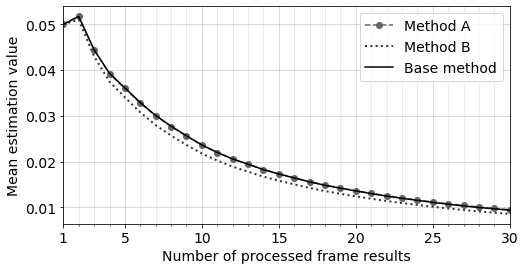

In [137]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams.update({'font.size': 14})

plt.clf()
plt.cla()

plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.gca().set_xticks([1] + [5 * (i + 1) for i in range(6)])
plt.gca().yaxis.set_major_locator(MultipleLocator(0.01))
plt.grid(which = 'minor', alpha = 0.3)
plt.grid(which = 'major', alpha = 0.6)

for method in ['summation', 'treap', 'base']:
    x, y = collect_estimation_datapoints(method)
    plt.plot(x, y, \
             label = PLOT_LABEL[method], \
             color = PLOT_COLOR[method], \
             linestyle = PLOT_LINESTYLE[method], \
             marker = PLOT_MARKER[method], \
             markersize = PLOT_MARKERSIZE[method], \
             linewidth = PLOT_LINEWIDTH[method])

plt.xlim([1, 30])

plt.legend()

plt.xlabel(r'Number of processed frame results')
plt.ylabel('Mean estimation value')

plt.savefig('estimations.pdf', dpi=1200, bbox_inches='tight', pad_inches=0)

#### Comparing the estimation time

In [138]:
def collect_timing_datapoints(method):
    '''
    Collects timing values for estimation 
    '''
    precalc_dir = PRECALC_DIRECTORIES[method]
    
    x = [1.0 * (i + 1) for i in range(30)]
    y = [0.0 for i in range(30)]
    
    precalc_files = [os.path.join(precalc_dir, x) for x in os.listdir(precalc_dir)]
    for precalc_file in precalc_files:
        precalc_data = None
        with open(precalc_file) as js:
            precalc_data = json.load(js)
        for i in range(30):
            y[i] += precalc_data[i][2] + precalc_data[i][3]
    
    for i in range(30):
        y[i] /= len(precalc_files)
    
    return x, y

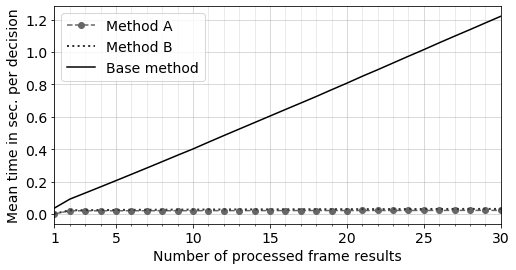

In [139]:
plt.clf()
plt.cla()

plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.gca().set_xticks([1] + [5 * (i + 1) for i in range(6)])
plt.grid(which = 'minor', alpha = 0.3)
plt.grid(which = 'major', alpha = 0.6)

for method in ['summation', 'treap', 'base']:
    x, y = collect_timing_datapoints(method)
    plt.plot(x, y, \
             label = PLOT_LABEL[method], \
             color = PLOT_COLOR[method], \
             linestyle = PLOT_LINESTYLE[method], \
             marker = PLOT_MARKER[method], \
             markersize = PLOT_MARKERSIZE[method], \
             linewidth = PLOT_LINEWIDTH[method])

plt.xlim([1, 30])

plt.legend()

plt.xlabel(r'Number of processed frame results')
plt.ylabel('Mean time in sec. per decision')

plt.savefig('timing.pdf', dpi=1200, bbox_inches='tight', pad_inches=0)

#### Comparing expected performance profiles

In [140]:
def collect_counting_stopper_epp():
    '''
    Collects expected performance profile for a simple stopper which 
    stops after a fixed number of processed frames
    '''
    precalc_dir = PRECALC_DIRECTORIES['base']
    x = [1.0 * (i + 1) for i in range(30)]
    y = [0.0 for i in range(30)]
    
    precalc_files = [os.path.join(precalc_dir, x) for x in os.listdir(precalc_dir)]
    for precalc_file in precalc_files:
        precalc_data = None
        with open(precalc_file) as js:
            precalc_data = json.load(js)
        for i in range(30):
            y[i] += precalc_data[i][0]
    
    for i in range(30):
        y[i] /= len(precalc_files)
    
    return x, y

def collect_modelling_stopper_epp(method):
    '''
    Collects expected performance profile for a next combination result 
    modelling stopping method
    '''
    precalc_dir = PRECALC_DIRECTORIES[method]
    SMALL_DELTA = 0.1
    
    DATAPOINTS_COUNT = 300
    MIN_THRESHOLD = -0.001
    MAX_THRESHOLD = 0.15
    THRESHOLDS = [MIN_THRESHOLD + (MAX_THRESHOLD - MIN_THRESHOLD) * i / (DATAPOINTS_COUNT - 1) \
                  for i in range(DATAPOINTS_COUNT)]
    
    x = []
    y = []
    
    precalc = []
    precalc_files = [os.path.join(precalc_dir, x) for x in os.listdir(precalc_dir)]
    for precalc_file in precalc_files:
        precalc_data = None
        with open(precalc_file) as js:
            precalc_data = json.load(js)
        precalc.append(precalc_data)
    
    for threshold in THRESHOLDS:
        sum_clip_length = 0.0
        sum_error_level = 0.0
        
        for precalc_data in precalc:
            stopped = False
            clip_start = 1 if threshold <= 1.0 else 0
            for i in range(clip_start, 30):
                delta = (SMALL_DELTA + precalc_data[i][1]) / (i + 2)
                if delta <= threshold:
                    sum_clip_length += (i + 1)
                    sum_error_level += precalc_data[i][0]
                    stopped = True
                    break
            if not stopped:
                sum_clip_length += 30
                sum_error_level += precalc_data[-1][0]
                
        x.append(sum_clip_length / len(precalc))
        y.append(sum_error_level / len(precalc))
    
    return x, y

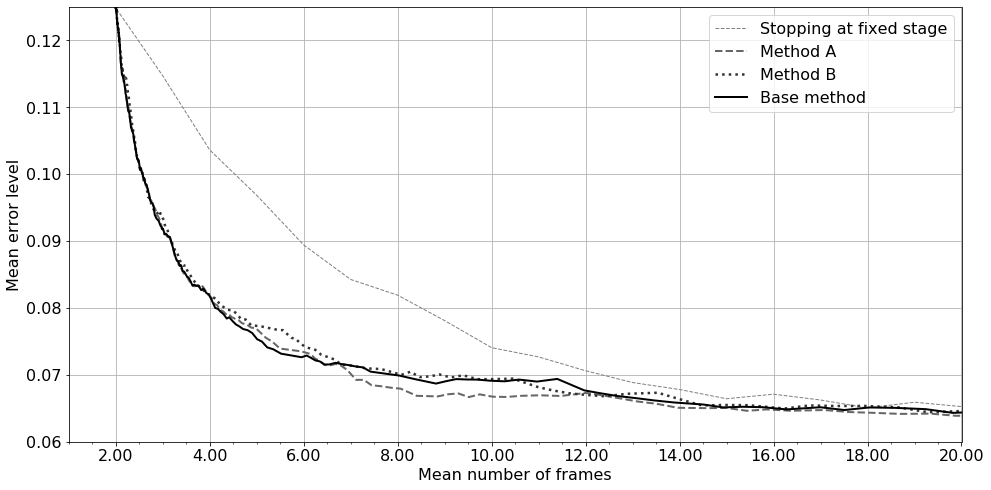

In [141]:
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams.update({'font.size': 16})

plt.clf()
plt.cla()

plt.gca().xaxis.set_minor_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_locator(MultipleLocator(2))

c_x, c_y = collect_counting_stopper_epp()
plt.plot(c_x, c_y, label=r'Stopping at fixed stage', color='0.5', linestyle='--', linewidth = 1)

PLOT_LINEWIDTH = { 'base': 2.0, 'summation': 2.0, 'treap': 2.5 }

for method in ['summation', 'treap', 'base']:
    x, y = collect_modelling_stopper_epp(method)
    plt.plot(x, y, \
             label = PLOT_LABEL[method], \
             color = PLOT_COLOR[method], \
             linestyle = PLOT_LINESTYLE[method], \
             linewidth = PLOT_LINEWIDTH[method])
    
plt.xlim([1, 20])
plt.ylim([0.06, 0.125])
plt.grid()
plt.legend()

plt.xlabel(r'Mean number of frames')
plt.ylabel('Mean error level')
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.savefig('epps.pdf', dpi=1200, bbox_inches='tight', pad_inches=0)